In [1]:
import gudhi as gd
from gudhi import representations
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats as st
from collections import defaultdict
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances
from tqdm.notebook import tqdm
import scipy.spatial.distance as spdists
from scipy.stats import ks_2samp
from pyEulerCurves import ECC_from_pointcloud
from bifiltration_utils import wasserstein_distance_ECP, bottleneck_distance_ECP

#from curlyBrace import curlyBrace
%matplotlib widget

In [47]:
def sampled_ecc_alpha(pointcloud, n_samples, max_filt_val):
    ac = gd.AlphaComplex(points = pointcloud)
    st = ac.create_simplex_tree()
    filt_values = np.linspace(0,max_filt_val,n_samples)
    ecc_values = np.zeros_like(filt_values)
    simplices = list(st.get_filtration())
    cur_val = 0
    i=0
    for (j,t) in enumerate(filt_values):
        while (i<len(simplices)) and (simplices[i][1]<=t):
            cur_val=cur_val +(-1)**(len(simplices[i][0])-1)
            i = i+1
        #print(t, cur_val)
        ecc_values[j] = cur_val
        
    return ecc_values

def sampled_bc_alpha(pointcloud, n_samples, max_filt_val, dim=0):
    ac = gd.AlphaComplex(points = pointcloud)
    st = ac.create_simplex_tree()
    st.compute_persistence()
    barcode = st.persistence_intervals_in_dimension(dim)
    bc = representations.BettiCurve(predefined_grid=np.linspace(0,max_filt_val,n_samples))
    return bc.fit_transform([barcode])[0]


In [3]:
def get_ecc(data, n_samples, max_filt_val):
    eccs = []
    for dat in tqdm(data):
        ec = sampled_ecc_alpha(dat, n_samples, max_filt_val)
        eccs.append(ec)
    return eccs

In [4]:
def ecc_distance(samples1, samples2, n_samples, max_filt_val):
    ECCs1 = get_ecc(samples1, n_samples = n_samples, max_filt_val = max_filt_val)
    ECCs2 = get_ecc(samples2, n_samples = n_samples, max_filt_val = max_filt_val)
    #dists = paired_distances(ECCs1,ECCs2, n_jobs=-1, metric = spdists.chebyshev)
    dists = np.maximum(ECCs1-ECCs2)+np.maximum(ECCs2-ECCs1)
    return dists
    #dists = dists *(max_filt_val/(n_samples-1))
    #return dists.flatten()

In [5]:
def gen_rv(rv, N, n_samples):
    return [np.array([rv[0].rvs(N), rv[1].rvs(N).tolist(), rv[2].rvs(N).tolist()]).T for i in range(n_samples)]

In [6]:
rv_normal = st.norm()
rv_normal2_2 = st.norm(2,2)
rv_beta2_2 = st.beta(2, 2)
rv_beta5_5 = st.beta(5, 5)
rv_beta10_10 = st.beta(10, 10)
rv_laplace = st.laplace()
rv_uniform = st.uniform()
rv_t3 = st.t(df=3)
rv_t5 = st.t(df=5)
rv_t7 = st.t(df=7)
rv_t10 = st.t(df=10)
rv_gamma10_1 = st.gamma(10,1)
rv_gamma20_1 = st.gamma(20,1)
rv_gamma4_5 = st.gamma(4,5)
rv_gamma5_1= st.gamma(5,1)
rv_chisq4 = st.chi2(df=4)
rv_chisq10 = st.chi2(df=10)
rv_lorentz = st.cauchy()
rv_logistic = st.logistic()
rv_arcsine = st.arcsine()
rv_argus = st.argus(chi=1)
rv_cosine = st.cosine()

In [7]:
n=20
n_loops = 100
d = 3

rvs= [[rv_uniform, rv_uniform, rv_uniform],
      [rv_beta2_2, rv_beta2_2, rv_beta2_2],
      [rv_beta5_5, rv_beta5_5,rv_beta5_5],
      [rv_beta10_10, rv_beta10_10, rv_beta10_10],
      [rv_argus, rv_argus, rv_argus],
      [rv_arcsine, rv_arcsine, rv_arcsine],
      [rv_uniform, rv_beta10_10, rv_beta10_10],
      [rv_uniform, rv_uniform, rv_beta10_10]]

rv_names=["UxUxU",
          "B22xB22XB22",
          "B55xB55xB55",
          "B1010xB1010xB1010",
          "ArgusxArgusxArgus",
          "asinxasinxasin",
          "UxB1010xB1010",
          "UxUxB1010"]

In [8]:
samples = [(n**(1/3)) * np.array(gen_rv(rv,n,n_loops)) for rv in tqdm(rvs)]
samples2 = [(n**(1/3)) * np.array(gen_rv(rv,n,n_loops)) for rv in tqdm(rvs)]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [28]:
np.concatenate(samples[:2][0],axis=1).shape

(20, 300)

In [48]:
steps = 1001
maxfilt = 1.5
grid = np.linspace(0,maxfilt, steps)

H0_sum_bcs = np.zeros((len(rvs),n_loops,steps))
H0_mixed_bcs = np.zeros((len(rvs),n_loops,steps))

for j in range(len(rvs)):
    H0_sum_bcs[j] = np.array([sampled_bc_alpha(samples[j][i],steps,maxfilt)+sampled_bc_alpha(samples2[j][i],steps,maxfilt) for i in range (n_loops)])
    H0_mixed_bcs[j] = np.array([sampled_bc_alpha(2**(1/3)*np.concatenate([samples[j][i],samples2[j][i]]),steps,maxfilt) for i in range(n_loops)])


/tmp/ipykernel_1151/3703323516.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f,ax = plt.subplots(1,2,figsize=(10,5))


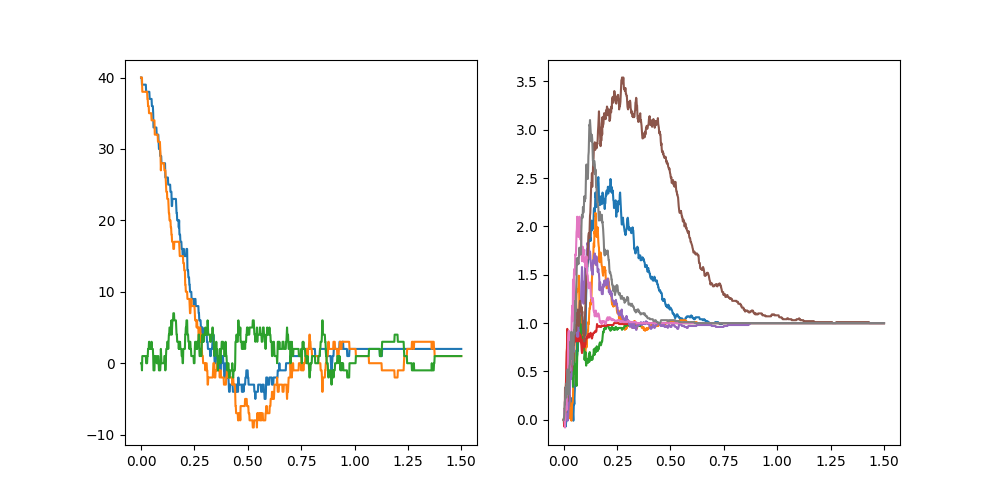

In [53]:

f,ax = plt.subplots(1,2,figsize=(10,5))
ax[0]. plot(grid, sampled_ecc_alpha(samples[0][0],steps,maxfilt)+sampled_ecc_alpha(samples[0][1],steps,maxfilt))
ax[0]. plot(grid, sampled_ecc_alpha(2**(1/3)*np.concatenate(samples[0][:2]),steps,maxfilt))
ax[0]. plot(grid, sampled_ecc_alpha(samples[0][0],steps,maxfilt)+sampled_ecc_alpha(samples[0][1],steps,maxfilt)-sampled_ecc_alpha(2**(1/3)*np.concatenate(samples[0][:2]),steps,maxfilt))

for i in range(len(rvs)):
    #ax[1]. plot(grid, np.mean(H0_sum_bcs[i], axis=0))
    #ax[1]. plot(grid, np.mean(H0_mixed_bcs[i], axis=0))
    ax[1]. plot(grid, np.mean(H0_sum_bcs[i]-H0_mixed_bcs[i], axis=0))

plt.show()

In [11]:
ecc_dists = np.zeros((len(rvs),n_loops))
trafo = ECC_from_pointcloud(epsilon=2, workers=4)
eccs1 = [[trafo.fit_transform(s) for s in x] for x in samples]
eccs2 = [[trafo.fit_transform(s) for s in x] for x in samples2]

#eccs_mean = np.mean(eccs1, axis =1)


In [38]:

for i in tqdm(range(0,len(rvs))):
    for j in range(n_loops):
        ecc_dists[i][j] = bottleneck_distance_ECP(eccs1[i][j],eccs2[i][j])
    #index_plus = np.argmax(eccs1[i]-eccs2[i],axis=1)
    #index_minus = np.argmax(eccs2[i]-eccs1[i],axis=1)

    #ecc_dists[i] = (np.log(eccs1[i][index_plus]/eccs2[i][index_plus]))+(np.log(eccs2[i][index_minus]-eccs1[i][index_minus]))

  0%|          | 0/8 [00:00<?, ?it/s]

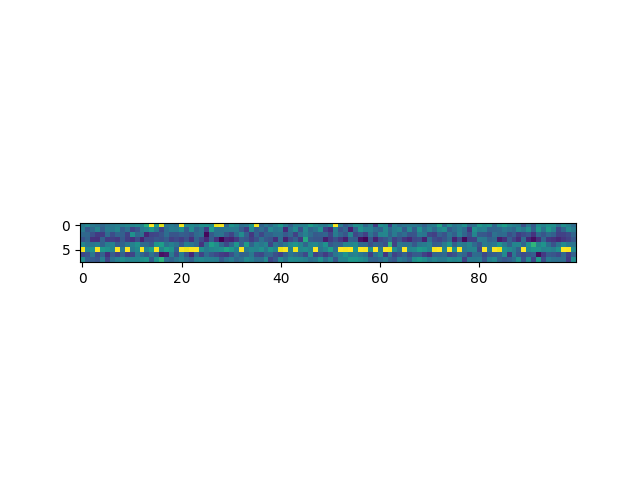

In [44]:
f,ax=plt.subplots()
ax.imshow(np.log(ecc_dists))
plt.show()

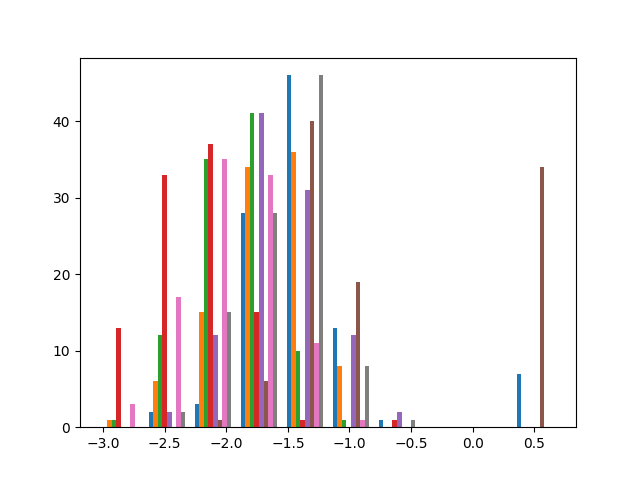

In [41]:
f,ax = plt.subplots()
ax.hist(np.log(ecc_dists).T)
plt.show()

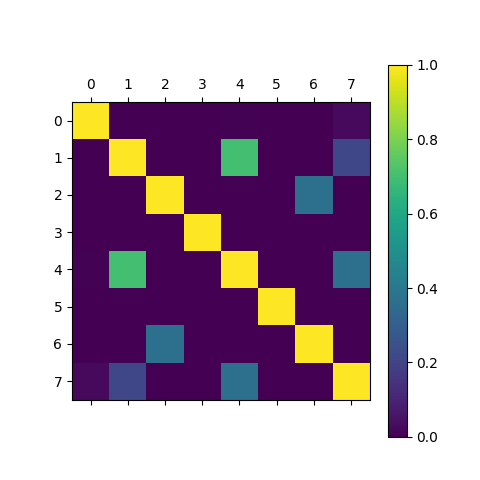

In [43]:
pvals = np.zeros((len(rvs),len(rvs)))
for i in range(0,len(rvs)):
    for j in range(0,len(rvs)):
        pvals[i][j] = ks_2samp(np.log(ecc_dists)[i], np.log(ecc_dists)[j])[1]

plt.matshow(pvals)
plt.colorbar()

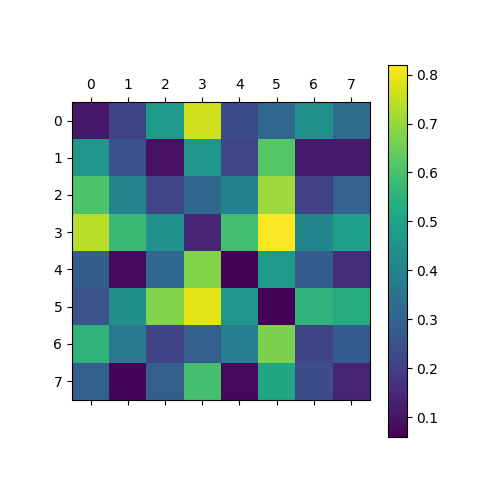

In [37]:
pvals = np.zeros((len(rvs),len(rvs)))
for i in range(0,len(rvs)):
    for j in range(0,len(rvs)):
        pvals[i][j] = ks_2samp(pairwise_distances(samples[i][0], n_jobs=-1).flatten(),pairwise_distances(samples2[j][0], n_jobs=-1).flatten())[0]

plt.matshow(pvals)
plt.colorbar()